# what is Pneumonia

Pneumonia is an infection in your lungs caused by bacteria, viruses or fungi. Pneumonia causes your lung tissue to swell (inflammation) and can cause fluid or pus in your lungs. Bacterial pneumonia is usually more severe than viral pneumonia, which often resolves on its own.

Pneumonia can affect one or both lungs. Pneumonia in both of your lungs is called bilateral or double pneumonia

# Dataset 

Acess data source :  https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.




# Import libraries

check all depences download in kaggl in this notebook 

In [1]:
#!pip freeze

To use TPU (Tensor Processing Unit) in a Kaggle notebook, you can follow these steps:

In [2]:
#import tensorflow as tf
#print("TensorFlow version:", tf.__version__)
#print("TPU available:", "Yes" if tf.config.experimental.list_logical_devices('TPU') else "No")

In [3]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

2024-04-30 13:57:56.233737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 13:57:56.233849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 13:57:56.403294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Accessing data**

In [4]:
path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'


# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'

**find all files, our files has extension jpeg***

In [5]:
# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]

**make new images path**

In [6]:
# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]

**create lists for train, test & validation cases, create labels as well**

In [7]:
# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)

**Create DataFrames**

In [8]:
# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

**Train data**

In [9]:
train_df

,image,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


**Test Data**

In [10]:
test_df

,image,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
...,...,...
619,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
621,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
622,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


**Validation data**

In [11]:
val_df

,image,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


## Checking Image Samples

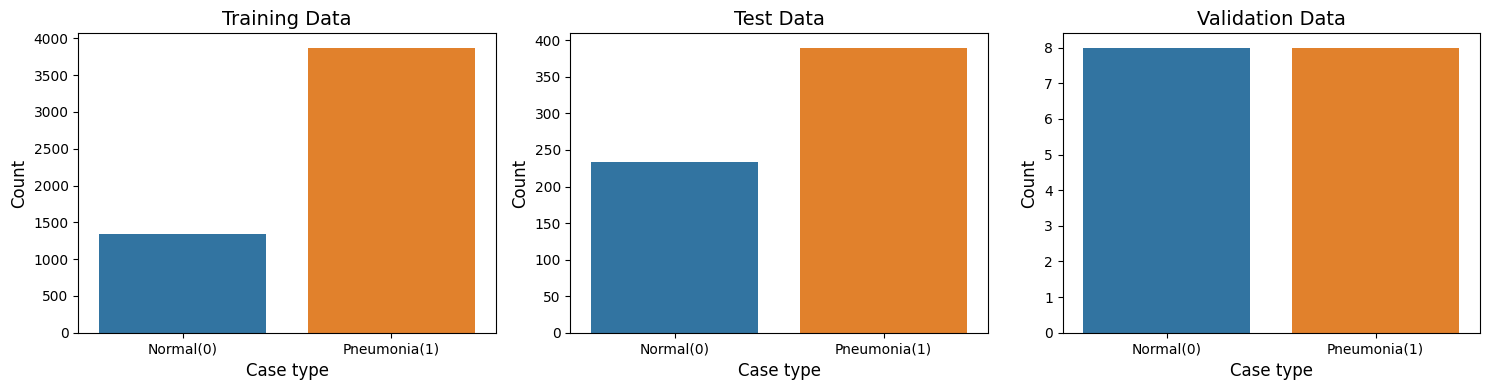

In [12]:
def plot_cases_count(df, title, ax):
    cases_count = df['label'].value_counts()
    
    sns.barplot(x=cases_count.index, y= cases_count.values, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(['Normal(0)', 'Pneumonia(1)'])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for Training Data
plot_cases_count(train_df, 'Training Data', axes[0])

# Plot for Test Data
plot_cases_count(test_df, 'Test Data', axes[1])

# Plot for Validation Data
plot_cases_count(val_df, 'Validation Data', axes[2])

plt.tight_layout()
plt.show()

**Show  dataframe  some images**

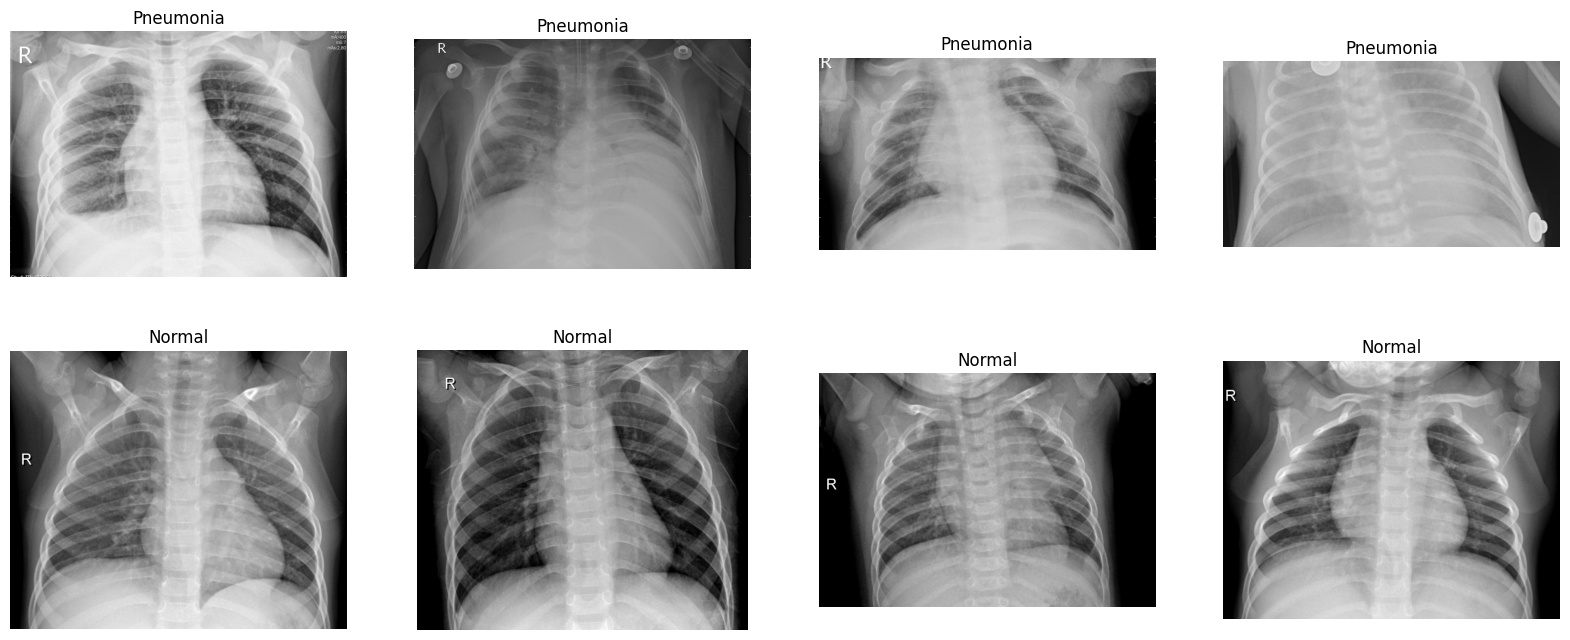

In [13]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

**images  resize**

In [14]:
#from PIL import Image
#import numpy as np

#def process_data(img_path):
    # Open image using PIL (Python Imaging Library)
    #img = Image.open(img_path)
    # Resize image to 224x224
    #img = img.resize((224, 224))
    # Convert image to grayscale
    #img = img.convert('L')
    # Convert image to numpy array and normalize pixel values
    #img_array = np.array(img) / 255.0
    # Reshape image to add channel dimension
    #img_array = np.reshape(img_array, (224, 224, 1))
    
    #return img_array

#def compose_dataset(df):
    #data = []
    #labels = []

    #for img_path, label in df.values:
        #data.append(process_data(img_path))
        #labels.append(label)
        
    #return np.array(data), np.array(labels)


In [15]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (224,224,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []
    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

**Compose dataset**

In [16]:
#import numpy as np
#import tensorflow as tf
#from sklearn.model_selection import train_test_split

In [17]:
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [18]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

**show data shape and labels shape**

In [19]:
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 224, 224, 1), Labels shape: (5216,)
Test data shape: (624, 224, 224, 1), Labels shape: (624,)
Validation data shape: (16, 224, 224, 1), Labels shape: (16,)


### Augmentation

In [20]:
# define generator
#datagen = ImageDataGenerator(
   # rotation_range=10,
   # zoom_range = 0.10,
   #$ width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=False,
    #vertical_flip=False)
# fit generator on our train features
#datagen.fit(X_train)

**one-hot encoding**

In [21]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Convolutional Neural Networks

In [22]:
#!pip install --upgrade tensorflow

**CNN Architecture**

In [23]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(7,7), padding='valid', activation='relu', input_shape=(224, 224, 1)))
model.add(Conv2D(filters=16, kernel_size=(7,7), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))


In [24]:
optimizer = Adam(learning_rate=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

**Model Training** 

In [25]:
callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(X_train,y_train, batch_size=4, validation_data=(X_test, y_test), epochs = 40 , verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/40
   6/1304 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.4694 - loss: 1.5025 

I0000 00:00:1714485625.397076      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1304/1304 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.3777 - loss: 0.8608 - val_accuracy: 0.8686 - val_loss: 0.3370
Epoch 2/40
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8314 - loss: 0.3515 - val_accuracy: 0.8814 - val_loss: 0.3133
Epoch 3/40
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8877 - loss: 0.2276 - val_accuracy: 0.8718 - val_loss: 0.3393
Epoch 4/40
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9153 - loss: 0.1727 - val_accuracy: 0.8782 - val_loss: 0.3191
Epoch 5/40
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9237 - loss: 0.1552 - val_accuracy: 0.8093 - val_loss: 0.6848
Epoch 6/40
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9399 - loss: 0.1302 - val_accuracy: 0.8429 - val_loss: 0.5442
Epoch 7/40
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9442 - loss: 0.1226 - val_accuracy: 0.8670 - val_loss: 0.3548
Epoch 8/40
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9623 - loss: 0.08

**Plot graph Loss on train data and  validation  data**

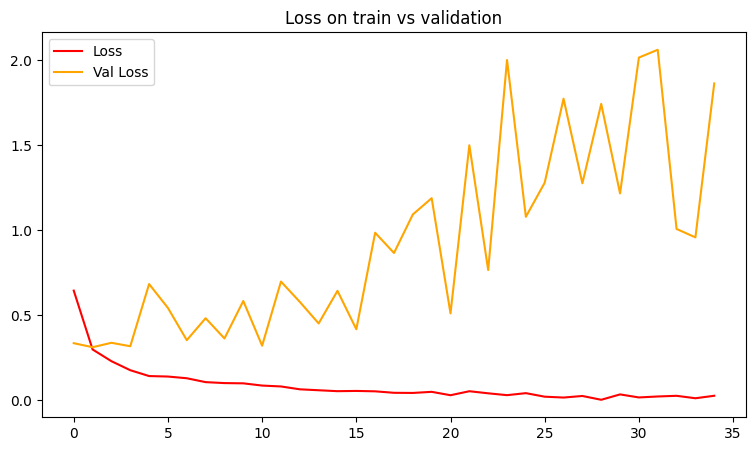

In [26]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

**plot graph  Accuracy on train data  and  validation data**

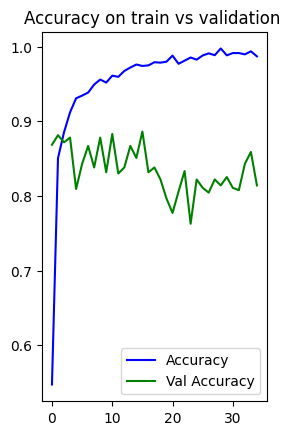

In [27]:

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs validation ')
plt.legend(loc='best')

plt.show()


# ml  model save 

In [40]:
model.save('/kaggle/working/saved_image_model5.h5')

## Model prediction on test data ##

In [29]:
#predictions for the test dataset X_test.
#The batch_size parameter specifies the number of samples to process at a time. 
#In this case, it's set to 4, meaning predictions will be made in batches of 4 samples


#y_test_hat = model.predict(X_test, batch_size=4) #predictions for the test dataset X_test 


# This line of code uses NumPy's argmax function to find the index of the maximum value along the 
#specified axis . 
#Here, y_test_hat is a NumPy array containing predicted values for each class 
#(e.g., probabilities for each class in a classification task).
#Setting axis=1 means the argmax function will find the index of the maximum value 
#along the second axis (i.e., along each row)


#y_test_hat = np.argmax(y_test_hat, axis=1)


#This line of code is similar to the previous one but applied to the true labels (y_test) of 
#the test dataset


#y_test = np.argmax(y_test, axis=1)

In [41]:
# Prediction
y_pred = model.predict(X_test)
# Predicting labels for the test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Converting one-hot encoded test labels back to categorical labels
y_true = np.argmax(y_test, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


# confusion matrix

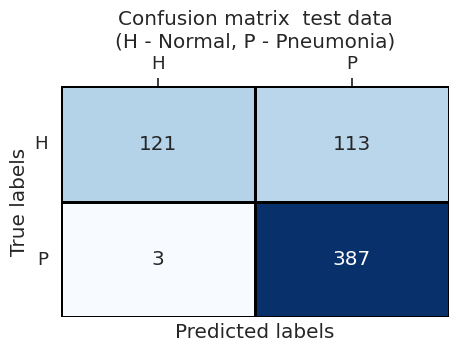

In [42]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_true, y_pred_classes)
clas_r = classification_report(y_true, y_pred_classes)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix  test data\n(H - Normal, P - Pneumonia)')
plt.show()

# Model Accuracy ,  Precision , Recall ,F1 Score

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [33]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"model test Accuracy: {accuracy:.8f}")


model test Accuracy: 0.81410256


In [34]:
# Precision
precision = precision_score(y_true, y_pred_classes)
print(f"Precision: {precision:.8f}")


Precision: 0.77400000


In [35]:
# Recall
recall = recall_score(y_true, y_pred_classes)
print(f"Recall: {recall:.8f}")

Recall: 0.99230769


In [36]:
# F1 Score
f1 = f1_score(y_true, y_pred_classes)
print(f"F1 Score: {f1:.8f}")

F1 Score: 0.86966292


# Receiver Operating Characteristic (ROC) Curve

AUC: 0.75470085


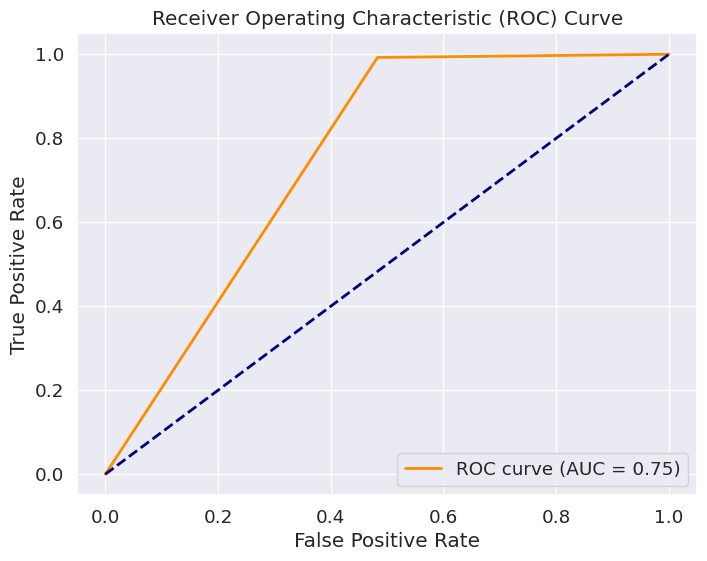

In [37]:


# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.8f}")

# Visualization of ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# classification report

In [38]:
# print classification report
print('Classification report on test data')
print(clas_r)

Classification report on test data
              precision    recall  f1-score   support

           0       0.98      0.52      0.68       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



# display  one by one Input image then model prediction reasult

In [43]:
from tensorflow.keras.models import load_model
from PIL import Image

# Load the saved model

model_path = '/kaggle/working/saved_image_model5.h5'
# Load the saved model
loaded_model = load_model(model_path)

# Define class labels
class_labels = ["NORMAL", "PNEUMONIA"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (1, 224, 224, 1))
    return img


# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    predicted_class_probability = prediction[0][predicted_class_index]
    negative_class_index = 1 - predicted_class_index
    negative_class_probability = prediction[0][negative_class_index]

    # Display probabilities
    print("Positive Probability (Predicted Class):", predicted_class_probability)
    print("Negative Probability (Opposite Class):", negative_class_probability)
    
    return predicted_class, probability

In [44]:
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0009-0001.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Positive Probability (Predicted Class): 1.0
Negative Probability (Opposite Class): 1.1771138e-10
Predicted Class: NORMAL
Probability: 1.0


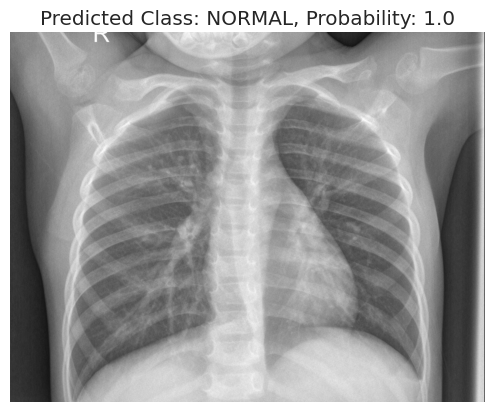

In [45]:
plt.imshow(cv2.imread(image_path))
plt.title(f'Predicted Class: {predicted_class}, Probability: {probability}')
plt.axis('off')
plt.show()

## display Some of the Correctly model prediction reasults

In [46]:
correct = np.nonzero(y_pred_classes == y_true)[0]

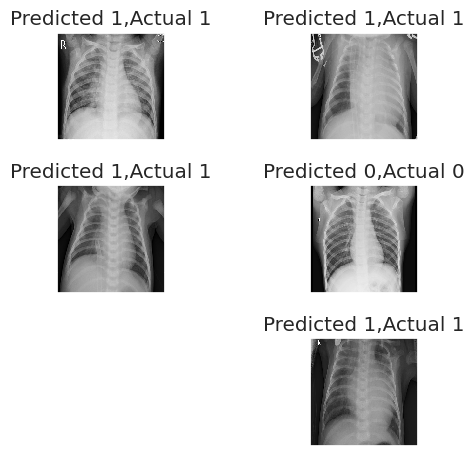

In [47]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(224,224), cmap="gray", interpolation='none')
    plt.title("Predicted {},Actual {}".format(y_pred_classes[c], y_true[c]))
    plt.tight_layout()
    i += 1

# display Some of the Incorrectly  model prediction reasults

In [48]:
incorrect = np.nonzero(y_pred_classes != y_true)[0]

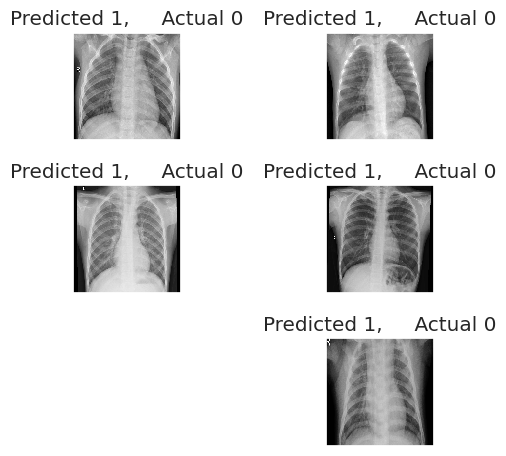

In [49]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(224,224), cmap="gray", interpolation='none')
    plt.title("Predicted {},     Actual {}".format(y_pred_classes[c], y_true[c]))
    plt.tight_layout()
    i += 1